In [117]:
import os
import sys
import time
from enum import Enum

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from functional import seq
from math import sqrt
from multiprocessing import Pool
import threading

# Load the "autoreload" extension
% reload_ext autoreload

# always reload modules marked with "%aimport"
% autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, os.pardir, 'src')
sys.path.append(src_dir)

In [152]:
class PeriodColumns(Enum):
    ID = 'id', 0
    LOW = 'low', 1
    HIGH = 'high', 2
    OPEN = 'open', 3
    CLOSE = 'close', 4
    WEIGHTED_AVERAGE = 'weightedAverage', 5
    VOLUME = 'volume', 6
    BASE_PRICE = 'basePrice', 7
    BASE_PRICE_BIN = 'basePriceBin', 8

    def __init__(self, column_name, index):
        self.column_name = column_name
        self.index = index


class BinColumns(Enum):
    BIN_ID = 'binId'
    AGG_VOLUME = 'aggVolume'
    LAST_PREVIOUS_BIN_ID = 'recentStrongestBinId'
    CONTAINS_BUY_ORDER = 'containsBuyOrder'

    OLD_LAST_AGG_VOLUME = 'oldLastAggVolume'
    OLD_LAST_MAX_VOLUME = 'oldLastMaxVolume'
    OLD_LAST_BASE_PRICE = 'oldLastBasePrice'
    OLD_ONE_BEFORE_LAST_AGG_VOLUME = 'oldOneBeforeLastAggVolume'
    OLD_ONE_BEFORE_LAST_MAX_VOLUME = 'oldOneBeforeLastMaxVolume'
    OLD_PERIOD_START = 'oldPeriodStart'
    OLD_PERIOD_END = 'oldPeriodEnd'
    OLD_BASE_SCORE = 'oldBaseScore'

    NEW_LAST_AGG_VOLUME = 'newLastAggVolume'
    NEW_LAST_MAX_VOLUME = 'newLastMaxVolume'
    NEW_LAST_BASE_PRICE = 'newLastBasePrice'
    NEW_ONE_BEFORE_LAST_AGG_VOLUME = 'newOneBeforeLastAggVolume'
    NEW_ONE_BEFORE_LAST_MAX_VOLUME = 'newOneBeforeLastMaxVolume'
    NEW_PERIOD_START = 'newPeriodStart'
    NEW_PERIOD_END = 'newPeriodEnd'
    NEW_BASE_SCORE = 'newBaseScore'

    def __init__(self, column_name):
        self.column_name = column_name


def calculate_profit_in_percents(sell_price_without_fee, buy_price_without_fee):
    sell_price_with_fee = sell_price_without_fee * (1 - trading_fee_decimal)
    buy_price_with_fee = buy_price_without_fee * (1 + trading_fee_decimal)
    return (sell_price_with_fee / buy_price_with_fee - 1) * 100


def add_trading_fee_to_volume(volume):
    return volume / (1 + trading_fee_decimal)


def subtract_trading_fee_from_volume(volume):
    return volume / (1 - trading_fee_decimal)


def calculate_trading_fee(price, volume):
    return price * volume * trading_fee_decimal


class CurrencyPair:
    def __init__(self, base_currency_symbol, target_currency_symbol, min_target_currency_investment):
        self.base_currency_symbol = base_currency_symbol
        self.target_currency_symbol = target_currency_symbol
        self.min_target_currency_investment = min_target_currency_investment

    def get_name(self):
        return '{}_{}'.format(self.base_currency_symbol, self.target_currency_symbol)


class Wallet:
    def __init__(self, currency_pair):
        self.currency_pair = currency_pair
        self.base_currency_amount = 0
        self.base_currency_paid_on_fees = 0
        self.target_currency_amount = 0

    def buy(self, price, volume):
        volume_with_fee = add_trading_fee_to_volume(volume)

        if self.base_currency_amount < price * volume_with_fee:
            bought_volume_without_fee = subtract_trading_fee_from_volume(self.base_currency_amount / price)
            self.target_currency_amount += bought_volume_without_fee
            self.base_currency_amount = 0
            self.base_currency_paid_on_fees += calculate_trading_fee(price, bought_volume_without_fee)
            return bought_volume_without_fee
        else:
            self.target_currency_amount += volume
            self.base_currency_amount -= price * volume_with_fee
            self.base_currency_paid_on_fees += calculate_trading_fee(price, volume)
            return volume

    def sell(self, price, volume):
        volume_with_fee = add_trading_fee_to_volume(volume)

        sold_volume_with_fee = min(self.target_currency_amount, volume_with_fee)
        sold_volume_without_fee = subtract_trading_fee_from_volume(sold_volume_with_fee)
        self.target_currency_amount -= sold_volume_with_fee
        self.base_currency_amount += price * sold_volume_without_fee
        self.base_currency_paid_on_fees += calculate_trading_fee(price, sold_volume_without_fee)
        return sold_volume_without_fee

    def get_total_in_base_currency(self, current_price):
        return self.base_currency_amount + current_price * self.target_currency_amount

    def to_string(self, current_price):
        return 'WALLET: {} {:9.4f}, {} {:9.4f} => in total {} {:9.4f}, spent on fees {} {:9.4f}'.format(
            self.currency_pair.base_currency_symbol, self.base_currency_amount,
            self.currency_pair.target_currency_symbol, self.target_currency_amount,
            self.currency_pair.base_currency_symbol, self.get_total_in_base_currency(current_price),
            self.currency_pair.base_currency_symbol, self.base_currency_paid_on_fees)


# Represents an outstanding order.
class OutstandingOrder:
    def __init__(self, price, volume):
        self.price = price
        self.volume = volume

    def to_string(self, current_price):
        return self.__str__()

    def draw(self, plt, total_period_count):
        pass


# Only drawing of sell order is currently supported. The reason is that buy orders are 
# immediately after their creation executed.
class OutstandingBuyOrder(OutstandingOrder):
    def __init__(self, buy_price, buy_volume, base_price, created_on_period_index, created_on_bin_index):
        super().__init__(buy_price, buy_volume)
        self.base_price = base_price
        self.created_on_period_index = created_on_period_index
        self.created_on_bin_index = created_on_bin_index

    def calculate_potential_profit_in_percents(self):
        return calculate_profit_in_percents(self.base_price, self.price)

    def __str__(self):
        return '{:4}: {} ({} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} {:6.2f}%'.format(
            'BUY',
            'prices', 'base', self.base_price, 'buy', self.price,
            'buyVol', self.volume,
            'createdOn', self.created_on_period_index,
            'potentialProfit', self.calculate_potential_profit_in_percents())


class OutstandingSellOrder(OutstandingOrder):
    def __init__(self, sell_price, sell_volume, buy_order_execution):
        super().__init__(sell_price, sell_volume)
        self.buy_order_execution = buy_order_execution

    def calculate_planned_profit_in_percents(self):
        return calculate_profit_in_percents(self.price, self.buy_order_execution.price)

    def calculate_current_profit_in_percents(self, current_price):
        return calculate_profit_in_percents(current_price, self.buy_order_execution.price)

    def to_string(self, current_price):
        return '{:4}: {} ({} {:7.2f}, {} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} ({} {:6.2f}%, {} {:6.2f}%)'.format(
            'SELL',
            'prices', 'base', self.buy_order_execution.order.base_price, 'bought', self.buy_order_execution.price,
            'sell', self.price,
            'sellVol', self.volume,
            'buyCreatedOn', self.buy_order_execution.order.created_on_period_index,
            'profit', 'planned', self.calculate_planned_profit_in_percents(), 'current',
            self.calculate_current_profit_in_percents(current_price))

    def draw(self, plt, total_period_count):
        color = 'red'
        line_style = 'dashed'
        line_width = (self.calculate_planned_profit_in_percents() / 10).astype('int') + 1

        # Vertical line from the buy point
        plt.plot([self.buy_order_execution.order.created_on_period_index,
                  self.buy_order_execution.order.created_on_period_index],
                 [self.buy_order_execution.price, self.price],
                 linestyle=line_style, color=color, linewidth=line_width)
        # Horizontal line to the sell point (different than in TradingHistoryEntry class in order to
        # mitigate overlapping)
        plt.plot([self.buy_order_execution.order.created_on_period_index, total_period_count],
                 [self.price, self.price],
                 linestyle=line_style, color=color, linewidth=line_width)


class OutstandingOrderManager:
    def __init__(self):
        self.orders = []

    def to_string(self, current_price):
        orders_string = '\n'.join(order.to_string(current_price) for order in self.orders)
        return 'ORDERS:\n{}'.format(orders_string)


class OrderExecution:
    def __init__(self, order, price, volume, executed_on_period_index):
        self.order = order
        self.price = price
        self.volume = volume
        self.executed_on_period_index = executed_on_period_index


class BuyOrderExecution(OrderExecution):
    def __init__(self, buy_order, bought_price, bought_volume, bought_on_period_index,
                 base_currency_remaining_amount):
        super().__init__(buy_order, bought_price, bought_volume, bought_on_period_index)
        self.base_currency_remaining_amount = base_currency_remaining_amount

    def calculate_potential_profit_in_percents(self):
        return calculate_profit_in_percents(self.order.base_price, self.price)

    def __str__(self):
        return '{:6}: {} ({} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} {:6.2f}%, {} {:7.2f}'.format(
            'BOUGHT',
            'prices', 'base', self.order.base_price, 'bought', self.price,
            'boughtVol', self.volume,
            'boughtOn', self.order.executed_on_period_index,
            'potentialProfit', self.calculate_potential_profit_in_percents(),
            'remainingBaseCurrency', self.base_currency_remaining_amount)

    def draw(self, plt):
        color = 'green'

        plt.plot(self.executed_on_period_index, self.price, marker='o', color=color)

        line_style = 'dotted'
        plt.plot([self.executed_on_period_index, self.executed_on_period_index],
                 [self.price, self.order.base_price],
                 linestyle=line_style, color=color)


class SellOrderExecution(OrderExecution):
    def __init__(self, sell_order, sold_price, sold_volume, sold_on_period_index):
        super().__init__(sell_order, sold_price, sold_volume, sold_on_period_index)

    def calculate_realized_profit_in_percents(self):
        return calculate_profit_in_percents(self.price, self.order.buy_order_execution.price)

    def calculate_realized_profit_decimal(self):
        return self.price * self.volume - self.order.buy_order_execution.price * self.order.buy_order_execution.volume

    def __str__(self):
        return '{:6}: {} ({} {:7.2f}, {} {:7.2f}, {} {:7.2f}), {} {:9.5f}, {} {:6.0f}, {} ({:6.2f}%, {:7.4f}),' \
               ' {} {:7.2f}'.format(
            'SOLD',
            'prices', 'base', self.order.buy_order_execution.order.base_price, 'bought',
            self.order.buy_order_execution.price, 'sold', self.price,
            'soldVol', self.volume,
            'soldOn', self.executed_on_period_index,
            'profit', self.calculate_realized_profit_in_percents(), self.calculate_realized_profit_decimal(),
            'buyRemainingBaseCurrency', self.order.buy_order_execution.base_currency_remaining_amount)

    def draw(self, plt):
        color = 'red'

        plt.plot(self.executed_on_period_index, self.price, marker='o', color=color)

        line_style = 'dotted'
        # Horizontal line from the buy point
        plt.plot([self.order.buy_order_execution.executed_on_period_index, self.executed_on_period_index],
                 [self.order.buy_order_execution.price, self.order.buy_order_execution.price],
                 linestyle=line_style, color=color)
        # Vertical line to the sell point
        plt.plot([self.executed_on_period_index, self.executed_on_period_index],
                 [self.order.buy_order_execution.price, self.price],
                 linestyle=line_style, color=color)


class TradingHistory:
    def __init__(self):
        self.order_executions = []

    def __str__(self):
        order_executions_string = '\n'.join(order_execution.__str__() for order_execution in self.order_executions if
                                            isinstance(order_execution, SellOrderExecution))
        return 'TRADING_HISTORY:\n{}'.format(order_executions_string)


class ExchangePlatform:
    def __init__(self, currency_pair):
        self.wallet = Wallet(currency_pair)
        self.outstanding_order_manager = OutstandingOrderManager()
        self.trading_history = TradingHistory()

    def deposit(self, base_currency_amount):
        self.wallet.base_currency_amount += base_currency_amount

    def determine_buy_order_volume(self, potential_profit_in_percents,
                                   last_base_score, current_price, algorithm_config):

        # 1% of the total money in the wallet expressed in the target currency
        one_percent_of_total_volume = (self.wallet.get_total_in_base_currency(
            current_price) / 100) / current_price

        profit_coefficient = sqrt(potential_profit_in_percents - algorithm_config.min_buy_order_profit_in_percents) \
                             * last_base_score * algorithm_config.volume_unit_target_currency_to_buy_in_percents

        number_of_percents_of_total_volume_to_buy = min(profit_coefficient,
                                                        algorithm_config.max_buy_order_volume_in_wallet_percents)

        # DO NOT DELETE
        # if number_of_percents_of_total_volume_to_buy == algorithm_config.max_buy_order_volume_in_wallet_percents:
        #     print('Max number of percents to buy reached (price {:7.2f})'.format(current_price))

        return number_of_percents_of_total_volume_to_buy * one_percent_of_total_volume

    def create_buy_order_if_wanted(self, current_period_index, current_price, last_base_score,
                                   last_base_last_base_price, current_bin_index, price_bins,
                                   currency_pair, algorithm_config):

        if price_bins.at[current_bin_index, BinColumns.CONTAINS_BUY_ORDER.column_name] == 1:
            # Only one not resolved buy order per bin.
            return

        potential_profit_in_percents = calculate_profit_in_percents(last_base_last_base_price, current_price)
        if potential_profit_in_percents > algorithm_config.min_buy_order_profit_in_percents:
            volume = self.determine_buy_order_volume(potential_profit_in_percents,
                                                     last_base_score, current_price, algorithm_config)
            if volume >= currency_pair.min_target_currency_investment:
                new_order = OutstandingBuyOrder(current_price, volume, last_base_last_base_price, current_period_index,
                                                current_bin_index)
                
                self.outstanding_order_manager.orders.append(new_order)
    
                price_bins.set_value(current_bin_index, BinColumns.CONTAINS_BUY_ORDER.column_name, 1)

    def create_sell_order(self, sell_price, sell_volume, buy_order_execution):
        new_sell_order = OutstandingSellOrder(sell_price, sell_volume, buy_order_execution)
        self.outstanding_order_manager.orders.append(new_sell_order)

    def create_sell_orders(self, buy_order_execution, currency_pair, algorithm_config):
        base_sell_price = buy_order_execution.order.base_price
        volume_to_get_investment_back = buy_order_execution.volume * (buy_order_execution.price / base_sell_price
                                                                      + algorithm_config.profit_to_get_back_investment)

        if buy_order_execution.volume - volume_to_get_investment_back < currency_pair.min_target_currency_investment:
            volume_to_get_investment_back = buy_order_execution.volume
        else:
            remaining_volume = buy_order_execution.volume - volume_to_get_investment_back
            progressive_coefficient = 1
            while remaining_volume > 0:
                sell_price = base_sell_price * (1 + progressive_coefficient * 0.01)
                sell_volume = remaining_volume / 2

                if remaining_volume - sell_volume < currency_pair.min_target_currency_investment:
                    sell_volume = remaining_volume
                    remaining_volume = 0
                else:
                    remaining_volume -= sell_volume

                self.create_sell_order(sell_price, sell_volume, buy_order_execution)

                progressive_coefficient *= 2

        self.create_sell_order(base_sell_price, volume_to_get_investment_back, buy_order_execution)

    def execute_buy_order(self, buy_order, current_price, current_period_index, price_bins, currency_pair,
                          algorithm_config):
        self.outstanding_order_manager.orders.remove(buy_order)
        if buy_order.price < current_price:
            # The price is higher than in buy order -> too expensive to buy. The order is being removed.
            price_bins.set_value(buy_order.created_on_bin_index, BinColumns.CONTAINS_BUY_ORDER.column_name, 0)

        else:
            realized_volume = self.wallet.buy(current_price, buy_order.volume)

            # DO NOT DELETE
            # if realized_volume < buy_order.volume:
            #     print('No {} in period {}'.format(self.wallet.currency_pair.base_currency_symbol,
            #                                       current_period_index))

            buy_order_execution = BuyOrderExecution(buy_order, current_price, realized_volume, current_period_index,
                                                    self.wallet.base_currency_amount)
            self.trading_history.order_executions.append(buy_order_execution)

            self.create_sell_orders(buy_order_execution, currency_pair, algorithm_config)

    def execute_sell_order_if_due(self, sell_order, current_price, current_period_index, price_bins):
        if sell_order.price > current_price:
            # The price is lower than in sell order -> too cheap to sell. The order is not resolved.
            return

        self.outstanding_order_manager.orders.remove(sell_order)
        realized_volume = self.wallet.sell(current_price, sell_order.volume)

        sell_order_execution = SellOrderExecution(sell_order, current_price, realized_volume, current_period_index)
        self.trading_history.order_executions.append(sell_order_execution)

        price_bins.set_value(sell_order.buy_order_execution.order.created_on_bin_index,
                             BinColumns.CONTAINS_BUY_ORDER.column_name, 0)

    def execute_order_if_due(self, order, current_price, current_period_index, price_bins, currency_pair,
                             algorithm_config):
        if isinstance(order, OutstandingBuyOrder):
            self.execute_buy_order(order, current_price, current_period_index, price_bins, currency_pair,
                                   algorithm_config)
        else:
            self.execute_sell_order_if_due(order, current_price, current_period_index, price_bins)

    def execute_due_orders(self, current_price, current_period_index, price_bins, currency_pair, algorithm_config):
        [self.execute_order_if_due(order, current_price, current_period_index, price_bins, currency_pair,
                                   algorithm_config) for order in self.outstanding_order_manager.orders]

    def to_string(self, current_price):
        return '\n{}\n\n{}\n\n{}'.format(self.trading_history, self.outstanding_order_manager.to_string(current_price),
                                         self.wallet.to_string(current_price))


class AlgorithmConfig:
    def __init__(self, max_base_score, volume_unit_target_currency_to_buy_in_percents,
                 multiplication_threshold, min_volume_per_period_threshold,
                 max_old_price_bin_count):
        self.max_base_score = max_base_score
        self.volume_unit_target_currency_to_buy_in_percents = volume_unit_target_currency_to_buy_in_percents
        self.multiplication_threshold = multiplication_threshold
        self.min_volume_per_period_threshold = min_volume_per_period_threshold
        self.max_old_price_bin_count = max_old_price_bin_count
        
        self.profit_to_get_back_investment = 0.01
        self.min_base_score = 0.5
        self.previous_and_current_base_keep_coefficient = 2
        self.min_buy_order_profit_in_percents = 2
        self.max_buy_order_volume_in_wallet_percents = 15
        self.initial_base_currency_amount = 100
        
    def __str__(self):
        return '{}={}, {}={}, {}={}, {}={}'.format(
            'max_base_score', self.max_base_score,
            'volume_unit_target_currency_to_buy_in_percents', self.volume_unit_target_currency_to_buy_in_percents,
            'multiplication_threshold', self.multiplication_threshold,
            'min_volume_per_period_threshold', self.min_volume_per_period_threshold)


def fetch_prices_json(currency_pair, now, oldest_period_offset, period_count, period_size_in_sec):
    start_date_time = now - oldest_period_offset * period_size_in_sec
    end_date_time = start_date_time + period_count * period_size_in_sec
    response = requests.get('https://poloniex.com/public?command=returnChartData', params={
        'currencyPair': currency_pair.get_name(),
        'start': start_date_time,
        'end': end_date_time,
        'period': period_size_in_sec
    })

    print(response.url)

    return response.json()


def fetch_periods_prices_jsons(currency_pair, old_week_count, new_week_count, new_week_offset):
    """
    old = historical data, i.e. can be analyzed together
    new = coming data, i.e. only the current period, previous periods and "old" periods are known, NOT future periods.
    """
    print('currency_pair={}'.format(currency_pair.get_name()))
    
    now = time.time()
    now_int = int(now)
    
    period_size_in_sec = 900
    one_week_in_periods = 60 * 60 * 24 * 7 / period_size_in_sec
    
    period_offset = new_week_offset * one_week_in_periods
    total_period_count = (old_week_count + new_week_count) * one_week_in_periods
    old_oldest_period_offset = total_period_count + period_offset
    old_period_count = old_week_count * one_week_in_periods
    new_oldest_period_offset = new_week_count * one_week_in_periods + period_offset
    new_period_count = new_week_count * one_week_in_periods
    
    # NOTE: old_periods and new_periods intersect probably in one second.
    old_periods_json = fetch_prices_json(currency_pair, now_int, old_oldest_period_offset, old_period_count,
                                         period_size_in_sec)
    new_periods_json = fetch_prices_json(currency_pair, now_int, new_oldest_period_offset, new_period_count,
                                         period_size_in_sec)
    return old_periods_json, new_periods_json, total_period_count, old_period_count


def determine_period_base_price(period_index, periods):
    if (periods.at[period_index, PeriodColumns.CLOSE.column_name] >=
            periods.at[period_index, PeriodColumns.OPEN.column_name]):
        return periods.at[period_index, PeriodColumns.LOW.column_name]
    else:
        return periods.at[period_index, PeriodColumns.HIGH.column_name]


# id_offset in order to render new periods after old ones.
def init_periods(periods_json, id_offset=0):
    # NOTE: Columns in to_pandas must follow the order in PeriodColumns!!!
    # ID prepended automatically perhaps because it is an index column.
    # BASE_PRICE and BASE_PRICE_BIN appended.
    periods = seq(periods_json).to_pandas([PeriodColumns.LOW.column_name,
                                           PeriodColumns.HIGH.column_name,
                                           PeriodColumns.OPEN.column_name,
                                           PeriodColumns.CLOSE.column_name,
                                           PeriodColumns.WEIGHTED_AVERAGE.column_name,
                                           PeriodColumns.VOLUME.column_name])

    periods_count = len(periods)

    # To be able to find for rows by id.
    periods[PeriodColumns.ID.column_name] = [i + id_offset for i in range(periods_count)]
    periods.set_index(PeriodColumns.ID.column_name, inplace=True)

    periods[PeriodColumns.BASE_PRICE.column_name] = [determine_period_base_price(i + id_offset, periods)
                                                     for i in range(periods_count)]
    return periods


def calculate_base_price_bin(period_base_price, price_bin_offset):
    return (period_base_price / price_bin_offset).astype('int') - 1


def init_old_periods(old_periods_json, max_old_price_bin_count):
    now = time.time()
    old_periods = init_periods(old_periods_json)
    # print('{}={}'.format('elapsed_time of init_periods', time.time() - now))

    old_min_price = old_periods[PeriodColumns.LOW.column_name].min()
    old_max_price = old_periods[PeriodColumns.HIGH.column_name].max()

    # The number of bins is based on the number of covered percentages.
    # If max_old_price_bin_count == 100 & old_min_price == 2000 USD & old_max_price == 5000 USD,
    # then covered 60% -> old_price_bin_count = 60 bins
    old_price_bin_count = ((1 - old_min_price / old_max_price) * max_old_price_bin_count).astype('int')
    price_bin_offset = old_max_price / max_old_price_bin_count
    # print('{}={}, {}={}'.format('old_price_bin_count', old_price_bin_count, 'price_bin_offset', price_bin_offset))
    old_periods[PeriodColumns.BASE_PRICE_BIN.column_name] = calculate_base_price_bin(
        old_periods[PeriodColumns.BASE_PRICE.column_name], price_bin_offset)

    return old_periods, price_bin_offset


def init_price_bins(price_bin_count):
    price_bins = pd.DataFrame({
        BinColumns.BIN_ID.column_name: range(price_bin_count)
    })
    price_bins.set_index(BinColumns.BIN_ID.column_name, inplace=True)
    price_bins[BinColumns.AGG_VOLUME.column_name] = [0.0 for i in range(price_bin_count)]
    price_bins[BinColumns.LAST_PREVIOUS_BIN_ID.column_name] = -10000
    
    price_bins[BinColumns.OLD_LAST_AGG_VOLUME.column_name] = [-10000.0 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_LAST_MAX_VOLUME.column_name] = [-10000.0 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_LAST_BASE_PRICE.column_name] = [-10000.0 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME.column_name] = [-10000.0 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME.column_name] = [-10000.0 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_PERIOD_START.column_name] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_PERIOD_END.column_name] = [-10000 for i in range(price_bin_count)]
    price_bins[BinColumns.OLD_BASE_SCORE.column_name] = [0.0 for i in range(price_bin_count)]

    return price_bins


def append_new_price_bin(price_bin_id_to_append, price_bins):
    new_price_bin_data = [{
        BinColumns.AGG_VOLUME.column_name: 0.0,
        BinColumns.LAST_PREVIOUS_BIN_ID.column_name: -10000,

        BinColumns.OLD_LAST_AGG_VOLUME.column_name: -10000.0,
        BinColumns.OLD_LAST_MAX_VOLUME.column_name: -10000.0,
        BinColumns.OLD_LAST_BASE_PRICE.column_name: -10000.0,
        BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME.column_name: -10000.0,
        BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME.column_name: -10000.0,
        BinColumns.OLD_PERIOD_START.column_name: -10000,
        BinColumns.OLD_PERIOD_END.column_name: -10000,
        BinColumns.OLD_BASE_SCORE.column_name: 0.0,

        BinColumns.NEW_LAST_AGG_VOLUME.column_name: -10000.0,
        BinColumns.NEW_LAST_MAX_VOLUME.column_name: -10000.0,
        BinColumns.NEW_LAST_BASE_PRICE.column_name: -10000.0,
        BinColumns.NEW_ONE_BEFORE_LAST_AGG_VOLUME.column_name: -10000.0,
        BinColumns.NEW_ONE_BEFORE_LAST_MAX_VOLUME.column_name: -10000.0,
        BinColumns.NEW_PERIOD_START.column_name: -10000,
        BinColumns.NEW_PERIOD_END.column_name: -10000,
        BinColumns.NEW_BASE_SCORE.column_name: 0.0
    }]
    new_price_bin = pd.DataFrame(new_price_bin_data, index=[price_bin_id_to_append])
    # Returns a new pandas with the appended new price bin.
    return price_bins.append(new_price_bin)


def append_new_price_bins(price_bin_id_to_add, price_bins):
    for bin_id in range(price_bins.last_valid_index() + 1, price_bin_id_to_add + 1):
        price_bins = append_new_price_bin(bin_id, price_bins)
    return price_bins


def calculate_base_score(bin_last_max_volume, bin_one_before_last_max_volume, moving_overall_bin_max_volume,
                         algorithm_config):
    score_basis = bin_last_max_volume / moving_overall_bin_max_volume
    if bin_one_before_last_max_volume == 0:
        score = score_basis  # No trend known.
    else:
        score = score_basis * (bin_last_max_volume / bin_one_before_last_max_volume)  # Considers the trend.
    return min(score, algorithm_config.max_base_score)

In [119]:
def update_price_bin_if_bin_change(bin_index, bin_base_price,
                                   bin_agg_volume, bin_max_volume,
                                   bin_start_period_included, bin_end_period_excluded,
                                   previous_bin_index,
                                   previous_bin_agg_volume, previous_bin_max_volume,
                                   price_bins,
                                   algorithm_config, moving_overall_bin_max_volume,
                                   base_score_column, last_agg_volume_column,
                                   last_base_price_column, last_max_volume_column,
                                   one_before_last_agg_volume_column, one_before_last_max_volume_column,
                                   period_end_column, period_start_column):
    total_bin_agg_volume = bin_agg_volume + price_bins.at[bin_index, BinColumns.AGG_VOLUME.column_name]
    price_bins.set_value(bin_index, BinColumns.AGG_VOLUME.column_name, total_bin_agg_volume)
    price_bins.set_value(bin_index, BinColumns.LAST_PREVIOUS_BIN_ID.column_name, previous_bin_index)

    bin_last_max_volume = price_bins.at[bin_index, last_max_volume_column.column_name]

    # If a previous base in this price bin exists.
    if bin_last_max_volume >= 0:
        price_bins.set_value(bin_index, one_before_last_agg_volume_column.column_name,
                             price_bins.at[bin_index, last_agg_volume_column.column_name])
        price_bins.set_value(bin_index, one_before_last_max_volume_column.column_name,
                             bin_last_max_volume)

    bin_mean_volume_per_period = bin_agg_volume / (bin_end_period_excluded - bin_start_period_included)

    # If a previous base in this price exists,
    # or there is a major different between the previous max volume and this one.
    if (bin_last_max_volume >= 0
        or (bin_max_volume > algorithm_config.multiplication_threshold * previous_bin_max_volume
            and bin_max_volume > algorithm_config.multiplication_threshold * algorithm_config.min_volume_per_period_threshold
            and bin_mean_volume_per_period > algorithm_config.min_volume_per_period_threshold)):

        moving_overall_bin_max_volume = max(moving_overall_bin_max_volume, bin_max_volume)

        if bin_mean_volume_per_period > algorithm_config.min_volume_per_period_threshold:
            new_base_score = calculate_base_score(bin_max_volume, bin_last_max_volume, moving_overall_bin_max_volume,
                                                  algorithm_config)
            if new_base_score >= algorithm_config.min_base_score:
                price_bins.set_value(bin_index, base_score_column.column_name, new_base_score)
            else:
                price_bins.set_value(bin_index, base_score_column.column_name, 0)
        else:
            price_bins.set_value(bin_index, base_score_column.column_name, 0)

        price_bins.set_value(bin_index, last_agg_volume_column.column_name, bin_agg_volume)
        price_bins.set_value(bin_index, last_max_volume_column.column_name, bin_max_volume)
        price_bins.set_value(bin_index, last_base_price_column.column_name, bin_base_price)

    if (bin_max_volume > algorithm_config.multiplication_threshold * previous_bin_max_volume
        and bin_max_volume > algorithm_config.multiplication_threshold * algorithm_config.min_volume_per_period_threshold
        and bin_mean_volume_per_period > algorithm_config.min_volume_per_period_threshold):

        if not (price_bins.at[bin_index, period_start_column.column_name] >= 0):
            price_bins.set_value(bin_index, period_start_column.column_name, bin_start_period_included)

    if price_bins.at[bin_index, period_start_column.column_name] >= 0:
        price_bins.set_value(bin_index, period_end_column.column_name, bin_end_period_excluded)

    return moving_overall_bin_max_volume


In [120]:
def update_price_bin_olds_if_bin_change(bin_index, bin_base_price,
                                        bin_agg_volume, bin_max_volume,
                                        bin_start_period_included, bin_end_period_excluded,
                                        previous_bin_index,
                                        previous_bin_agg_volume, previous_bin_max_volume,
                                        price_bins,
                                        algorithm_config, moving_overall_bin_max_volume):
    return update_price_bin_if_bin_change(bin_index, bin_base_price,
                                          bin_agg_volume, bin_max_volume,
                                          bin_start_period_included, bin_end_period_excluded,
                                          previous_bin_index,
                                          previous_bin_agg_volume, previous_bin_max_volume,
                                          price_bins,
                                          algorithm_config, moving_overall_bin_max_volume,
                                          BinColumns.OLD_BASE_SCORE, BinColumns.OLD_LAST_AGG_VOLUME,
                                          BinColumns.OLD_LAST_BASE_PRICE, BinColumns.OLD_LAST_MAX_VOLUME,
                                          BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME,
                                          BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME,
                                          BinColumns.OLD_PERIOD_END, BinColumns.OLD_PERIOD_START)

In [121]:
def update_price_bin_news_if_bin_change(bin_index, bin_base_price,
                                        bin_agg_volume, bin_max_volume,
                                        bin_start_period_included, bin_end_period_excluded,
                                        previous_bin_index,
                                        previous_bin_agg_volume, previous_bin_max_volume,
                                        price_bins,
                                        algorithm_config, moving_overall_bin_max_volume):
    return update_price_bin_if_bin_change(bin_index, bin_base_price,
                                          bin_agg_volume, bin_max_volume,
                                          bin_start_period_included, bin_end_period_excluded,
                                          previous_bin_index,
                                          previous_bin_agg_volume, previous_bin_max_volume,
                                          price_bins,
                                          algorithm_config, moving_overall_bin_max_volume,
                                          BinColumns.NEW_BASE_SCORE, BinColumns.NEW_LAST_AGG_VOLUME,
                                          BinColumns.NEW_LAST_BASE_PRICE, BinColumns.NEW_LAST_MAX_VOLUME,
                                          BinColumns.NEW_ONE_BEFORE_LAST_AGG_VOLUME,
                                          BinColumns.NEW_ONE_BEFORE_LAST_MAX_VOLUME,
                                          BinColumns.NEW_PERIOD_END, BinColumns.NEW_PERIOD_START)

In [122]:
def calculate_old_bins_base_score(old_periods, price_bins, algorithm_config, moving_overall_bin_max_volume):
    bin_index = -10000
    bin_base_price = -10000
    bin_agg_volume = -10000
    bin_max_volume = -10000
    bin_start_period = -10000

    previous_bin_index = -10000
    previous_bin_agg_volume = -10000
    previous_bin_max_volume = -10000

    period_index = -10000

    for row in old_periods.itertuples():
        period_index = row[PeriodColumns.ID.index]
        current_volume = row[PeriodColumns.VOLUME.index]
        current_bin_index = row[PeriodColumns.BASE_PRICE_BIN.index]

        if current_bin_index != bin_index:
            # The bin of the current period is a different one that has been being processed.

            if bin_index >= 0:
                moving_overall_bin_max_volume = update_price_bin_olds_if_bin_change(bin_index, bin_base_price,
                                                                                    bin_agg_volume, bin_max_volume,
                                                                                    bin_start_period, period_index,
                                                                                    previous_bin_index,
                                                                                    previous_bin_agg_volume,
                                                                                    previous_bin_max_volume,
                                                                                    price_bins,
                                                                                    algorithm_config,
                                                                                    moving_overall_bin_max_volume)

                previous_bin_index = bin_index
                previous_bin_agg_volume = bin_agg_volume
                previous_bin_max_volume = bin_max_volume

            bin_index = current_bin_index
            bin_base_price = row[PeriodColumns.BASE_PRICE.index]
            bin_agg_volume = current_volume
            bin_max_volume = current_volume
            bin_start_period = period_index

        else:
            bin_agg_volume += current_volume
            bin_max_volume = max(bin_max_volume, current_volume)
            if current_volume == bin_max_volume:
                bin_base_price = row[PeriodColumns.BASE_PRICE.index]

    if bin_index >= 0:
        # Bin from the last interaction of the loop above is being updated.
        moving_overall_bin_max_volume = update_price_bin_olds_if_bin_change(bin_index, bin_base_price,
                                                                            bin_agg_volume, bin_max_volume,
                                                                            bin_start_period, period_index + 1,
                                                                            previous_bin_index,
                                                                            previous_bin_agg_volume,
                                                                            previous_bin_max_volume,
                                                                            price_bins,
                                                                            algorithm_config,
                                                                            moving_overall_bin_max_volume)

    return price_bins, moving_overall_bin_max_volume


In [123]:
def extract_base_relevant_values_from_bin(bin_index, price_bins):
    base_score = price_bins.at[bin_index, BinColumns.OLD_BASE_SCORE.column_name]
    last_base_price = price_bins.at[bin_index, BinColumns.OLD_LAST_BASE_PRICE.column_name]
    return bin_index, base_score, last_base_price


In [124]:
def calculate_new_bins_base_score_and_invest(new_periods, exchange_platform,
                                             price_bin_offset, old_periods,
                                             price_bins,
                                             algorithm_config, moving_overall_bin_max_volume,
                                             currency_pair):
    
    price_bins[BinColumns.CONTAINS_BUY_ORDER.column_name] = [0 for i in range(len(price_bins))]

    # Copies values from OLD_ columns to NEW_ columns in order to keep the context, 
    price_bins[BinColumns.NEW_LAST_AGG_VOLUME.column_name] = price_bins[BinColumns.OLD_LAST_AGG_VOLUME.column_name]
    price_bins[BinColumns.NEW_LAST_MAX_VOLUME.column_name] = price_bins[BinColumns.OLD_LAST_MAX_VOLUME.column_name]
    price_bins[BinColumns.NEW_LAST_BASE_PRICE.column_name] = price_bins[BinColumns.OLD_LAST_BASE_PRICE.column_name]
    price_bins[BinColumns.NEW_ONE_BEFORE_LAST_AGG_VOLUME.column_name] = price_bins[
        BinColumns.OLD_ONE_BEFORE_LAST_AGG_VOLUME.column_name]
    price_bins[BinColumns.NEW_ONE_BEFORE_LAST_MAX_VOLUME.column_name] = price_bins[
        BinColumns.OLD_ONE_BEFORE_LAST_MAX_VOLUME.column_name]
    price_bins[BinColumns.NEW_PERIOD_START.column_name] = price_bins[BinColumns.OLD_PERIOD_START.column_name]
    price_bins[BinColumns.NEW_PERIOD_END.column_name] = price_bins[BinColumns.OLD_PERIOD_END.column_name]
    price_bins[BinColumns.NEW_BASE_SCORE.column_name] = price_bins[BinColumns.OLD_BASE_SCORE.column_name]

    # Retrieves data about the last OLD bin.
    bin_index = old_periods[PeriodColumns.BASE_PRICE_BIN.column_name].iloc[-1]
    bin_base_price = price_bins.at[bin_index, BinColumns.OLD_LAST_BASE_PRICE.column_name]
    bin_agg_volume = price_bins.at[bin_index, BinColumns.OLD_LAST_AGG_VOLUME.column_name]
    bin_max_volume = price_bins.at[bin_index, BinColumns.OLD_LAST_MAX_VOLUME.column_name]
    bin_start_period = price_bins.at[bin_index, BinColumns.OLD_PERIOD_START.column_name]

    # Retrieves data about the one before last OLD bin.
    previous_bin_index = price_bins.at[bin_index, BinColumns.LAST_PREVIOUS_BIN_ID.column_name]
    previous_bin_agg_volume = price_bins.at[previous_bin_index, BinColumns.OLD_LAST_AGG_VOLUME.column_name]\
        if previous_bin_index >= 0 else 0
    previous_bin_max_volume = price_bins.at[previous_bin_index, BinColumns.OLD_LAST_MAX_VOLUME.column_name]\
        if previous_bin_index >= 0 else 0

    # Information about the most recent strongest base if any in the last bins.
    last_base_bin_index = -10000
    last_base_score = -10000
    last_base_last_base_price = -10000
    if price_bins.at[bin_index, BinColumns.OLD_BASE_SCORE.column_name] > 0:
        (last_base_bin_index,
         last_base_score,
         last_base_last_base_price) = extract_base_relevant_values_from_bin(bin_index, price_bins)
    elif previous_bin_index >= 0 and price_bins.at[previous_bin_index, BinColumns.OLD_BASE_SCORE.column_name] > 0:
        (last_base_bin_index,
         last_base_score,
         last_base_last_base_price) = extract_base_relevant_values_from_bin(previous_bin_index, price_bins)

    period_index = -10000
    current_weighted_average = -10000

    for row in new_periods.itertuples():
        period_index = row[PeriodColumns.ID.index]
        current_volume = row[PeriodColumns.VOLUME.index]
        current_base_price = row[PeriodColumns.BASE_PRICE.index]
        current_bin_index = calculate_base_price_bin(current_base_price, price_bin_offset)
        price_bins = append_new_price_bins(current_bin_index, price_bins)

        if current_bin_index != bin_index:
            # The bin of the current period is a different one that has been being processed.

            if bin_index >= 0:
                moving_overall_bin_max_volume = update_price_bin_news_if_bin_change(bin_index, bin_base_price,
                                                                                    bin_agg_volume, bin_max_volume,
                                                                                    bin_start_period, period_index,
                                                                                    previous_bin_index,
                                                                                    previous_bin_agg_volume,
                                                                                    previous_bin_max_volume,
                                                                                    price_bins,
                                                                                    algorithm_config,
                                                                                    moving_overall_bin_max_volume)

                bin_base_score = price_bins.at[bin_index, BinColumns.NEW_BASE_SCORE.column_name]
                # The remembered base changes to the most recent one if this is strong enough.
                
                if bin_base_score > last_base_score / algorithm_config.previous_and_current_base_keep_coefficient\
                        or not (price_bins.at[last_base_bin_index, BinColumns.NEW_BASE_SCORE.column_name] > 0):
                    last_base_bin_index = bin_index
                    last_base_score = bin_base_score
                    last_base_last_base_price = bin_base_price

                previous_bin_agg_volume = bin_agg_volume
                previous_bin_max_volume = bin_max_volume

            bin_index = current_bin_index
            bin_base_price = current_base_price
            bin_agg_volume = current_volume
            bin_max_volume = current_volume
            bin_start_period = period_index

        else:
            bin_agg_volume += current_volume
            bin_max_volume = max(bin_max_volume, current_volume)
            if current_volume == bin_max_volume:
                bin_base_price = current_base_price

        current_weighted_average = row[PeriodColumns.WEIGHTED_AVERAGE.index]

        exchange_platform.create_buy_order_if_wanted(period_index, current_weighted_average, last_base_score,
                                                     last_base_last_base_price, current_bin_index, price_bins,
                                                     currency_pair, algorithm_config)
        exchange_platform.execute_due_orders(current_weighted_average, period_index, price_bins, currency_pair,
                                             algorithm_config)

    if bin_index >= 0:
        # Bin from the last interaction of the loop above is being updated.
        moving_overall_bin_max_volume = update_price_bin_news_if_bin_change(bin_index, bin_base_price,
                                                                            bin_agg_volume, bin_max_volume,
                                                                            bin_start_period, period_index + 1,
                                                                            previous_bin_index,
                                                                            previous_bin_agg_volume,
                                                                            previous_bin_max_volume,
                                                                            price_bins,
                                                                            algorithm_config,
                                                                            moving_overall_bin_max_volume)

    exchange_platform.execute_due_orders(current_weighted_average, period_index, price_bins, currency_pair,
                                         algorithm_config)

    return price_bins, moving_overall_bin_max_volume

In [125]:
def evaluate_algorithm(old_periods, price_bin_offset, new_periods_json, old_period_count, currency_pair,
                       algorithm_config):
    now = time.time()
    
    if trading_fee_decimal > algorithm_config.profit_to_get_back_investment:
        print('ERROR: {} ({}) > {} ({}). Must be the other way around in order to'
              ' get the initial investment back ASAP'.format('trading_fee_decimal', trading_fee_decimal,
                                                             'profit_to_get_back_investment',
                                                             algorithm_config.profit_to_get_back_investment))
    
    price_bins = init_price_bins(algorithm_config.max_old_price_bin_count)
    
    moving_overall_bin_max_volume = 0
    price_bins, moving_overall_bin_max_volume = calculate_old_bins_base_score(old_periods,
                                                                              price_bins,
                                                                              algorithm_config,
                                                                              moving_overall_bin_max_volume)
    
    new_periods = init_periods(new_periods_json, old_period_count)
    
    exchange_platform = ExchangePlatform(currency_pair)
    exchange_platform.deposit(algorithm_config.initial_base_currency_amount)
    price_bins, moving_overall_bin_max_volume = calculate_new_bins_base_score_and_invest(new_periods,
                                                                                         exchange_platform,
                                                                                         price_bin_offset,
                                                                                         old_periods,
                                                                                         price_bins,
                                                                                         algorithm_config,
                                                                                         moving_overall_bin_max_volume,
                                                                                         currency_pair)
    
    print('{}={}'.format('elapsed_time of evaluate_algorithm', time.time() - now))
    
    return new_periods, exchange_platform, price_bins, moving_overall_bin_max_volume

In [126]:
def draw_base_if_exists(price_bin, plt,
                        base_score_column, last_base_price_column, period_start_column, period_end_column,
                        drawing_period_count_offset=0):
    if price_bin[base_score_column.column_name] > 0:
        current_base_price = price_bin[last_base_price_column.column_name]
        line_width = (price_bin[base_score_column.column_name] / 0.3).astype('int') + 1

        # start is included, end is excluded
        plt.plot([price_bin[period_start_column.column_name] - drawing_period_count_offset,
                  price_bin[period_end_column.column_name] - 1 + drawing_period_count_offset],
                 [current_base_price, current_base_price],
                 color='purple', linewidth=line_width, label=current_base_price)


def draw_graph(old_periods, new_periods, total_period_count, old_new_border_period, exchange_platform, price_bins):
    plt.rcParams['figure.figsize'] = (50, 25)

    plt.plot(old_periods[PeriodColumns.WEIGHTED_AVERAGE.column_name])
    plt.plot(new_periods[PeriodColumns.WEIGHTED_AVERAGE.column_name])
    plt.plot([old_new_border_period, old_new_border_period],
             plt.gca().get_ylim(),
             color='grey')

    for index, row in price_bins.iterrows():
        draw_base_if_exists(row, plt, BinColumns.OLD_BASE_SCORE, BinColumns.OLD_LAST_BASE_PRICE,
                            BinColumns.OLD_PERIOD_START, BinColumns.OLD_PERIOD_END)
        draw_base_if_exists(row, plt, BinColumns.NEW_BASE_SCORE, BinColumns.NEW_LAST_BASE_PRICE,
                            BinColumns.NEW_PERIOD_START, BinColumns.NEW_PERIOD_END)

    [order_execution.draw(plt) for order_execution in exchange_platform.trading_history.order_executions]
    [order.draw(plt, total_period_count=total_period_count) for order
     in exchange_platform.outstanding_order_manager.orders]

    plt.grid()
    plt.show()


def print_bins_result_debug_info(price_bins):
    print('\nPRICE BINS - OLD:')
    for index, row in price_bins.iterrows():
        if row[BinColumns.OLD_BASE_SCORE.column_name] > 0 and row[BinColumns.NEW_BASE_SCORE.column_name] == 0:
            print(
                '{}={:3.0f}, {}={:10.0f}, {}={:6.2f}, {}={:6.2f}, {}={:8.2f}, {}={:8.2f}, {}={:.2f}, {}={:.2f}'
                .format(
                    'bin', index,
                    'aggVol', row[BinColumns.AGG_VOLUME.column_name],
                    'oPrc', row[BinColumns.OLD_LAST_BASE_PRICE.column_name],
                    'nPrc', row[BinColumns.NEW_LAST_BASE_PRICE.column_name],
                    'oMaxVol', row[BinColumns.OLD_LAST_MAX_VOLUME.column_name],
                    'nMaxVol', row[BinColumns.NEW_LAST_MAX_VOLUME.column_name],
                    'oScr', row[BinColumns.OLD_BASE_SCORE.column_name],
                    'nScr', row[BinColumns.NEW_BASE_SCORE.column_name]))

    print('\nPRICE BINS - NEW:')
    for index, row in price_bins.iterrows():
        if row[BinColumns.NEW_BASE_SCORE.column_name] > 0:
            print(
                '{}={:3.0f}, {}={:10.0f}, {}={:6.2f}, {}={:6.2f}, {}={:8.2f}, {}={:8.2f}, {}={:.2f}, {}={:.2f}'
                .format(
                    'bin', index,
                    'aggVol', row[BinColumns.AGG_VOLUME.column_name],
                    'oPrc', row[BinColumns.OLD_LAST_BASE_PRICE.column_name],
                    'nPrc', row[BinColumns.NEW_LAST_BASE_PRICE.column_name],
                    'oMaxVol', row[BinColumns.OLD_LAST_MAX_VOLUME.column_name],
                    'nMaxVol', row[BinColumns.NEW_LAST_MAX_VOLUME.column_name],
                    'oScr', row[BinColumns.OLD_BASE_SCORE.column_name],
                    'nScr', row[BinColumns.NEW_BASE_SCORE.column_name]))


def get_current_price(new_periods):
    return new_periods[PeriodColumns.CLOSE.column_name].iloc[-1]


def print_verbose_result_with_graph(old_periods, new_periods, total_period_count, old_period_count,
                                    exchange_platform, price_bins, moving_overall_bin_max_volume):
    now = time.time()

    draw_graph(old_periods, new_periods, total_period_count, old_period_count, exchange_platform, price_bins)

    print('{}={:9.0f}'.format('moving_overall_bin_max_volume', moving_overall_bin_max_volume))
    print_bins_result_debug_info(price_bins)

    current_price = get_current_price(new_periods)
    print(exchange_platform.to_string(current_price))

    print('{}={}'.format('elapsed_time of print_verbose_result_with_graph', time.time() - now))


def print_wallet(exchange_platform, new_periods):
    current_price = get_current_price(new_periods)
    print('{}\n'.format(exchange_platform.wallet.to_string(current_price)))

In [153]:
class CurrencyPairOneTimeFrameEvaluator:
    def __init__(self, currency_pair):
        self.currency_pair = currency_pair
        self.result_list = []

    def create_config_and_evaluate_algorithm(self, max_base_score, volume_unit_target_currency_to_buy_in_percents,
                                             old_periods_json, new_periods_json, total_period_count, old_period_count):
        max_old_price_bin_count = 200
        old_periods, price_bin_offset = init_old_periods(old_periods_json, max_old_price_bin_count)

        median_volume = old_periods[PeriodColumns.VOLUME.column_name].median()
        mean_volume = old_periods[PeriodColumns.VOLUME.column_name].mean()
        multiplication_threshold = 2 * mean_volume / median_volume
        min_volume_per_period_threshold = mean_volume
        algorithm_config = AlgorithmConfig(max_base_score, volume_unit_target_currency_to_buy_in_percents,
                                           multiplication_threshold, min_volume_per_period_threshold,
                                           max_old_price_bin_count)
        print(algorithm_config)

        new_periods, exchange_platform, price_bins, moving_overall_bin_max_volume = evaluate_algorithm(
            old_periods, price_bin_offset, new_periods_json, old_period_count, self.currency_pair, algorithm_config)

        print_verbose_result_with_graph(old_periods, new_periods, total_period_count, old_period_count,
                                        exchange_platform, price_bins, moving_overall_bin_max_volume)
        print_wallet(exchange_platform, new_periods)

        current_price = get_current_price(new_periods)
        target_coin_price_devaluated = current_price * 0.8
        wallet_value_in_base_currency = exchange_platform.wallet.get_total_in_base_currency(target_coin_price_devaluated)
        profit_in_percents = self.calculate_profit(wallet_value_in_base_currency,
                                                   algorithm_config.initial_base_currency_amount)

        return max_base_score, volume_unit_target_currency_to_buy_in_percents, profit_in_percents
        
    @staticmethod
    def calculate_profit(balance, investment):
        one_percent = investment / 100
        return (balance - investment) / one_percent

    def process_result(self, score_volume_profit_tuple):
        # This is called whenever create_config_and_evaluate_algorithm(..) returns a result.
        # result_list is modified only by the main process, not by the pool workers.
        self.result_list.append(score_volume_profit_tuple)
        
    @staticmethod
    def handle_error(error):
        print('ERROR={}'.format(error))


class CurrencyPairEvaluator:
    def __init__(self, currency_pair):
        self.currency_pair = currency_pair
    
    def evaluate_one_time_frame_and_draw_and_close(self, new_week_count):
        result_list_param, graph_thread = self.evaluate_one_time_frame_and_draw(new_week_count)
        graph_thread.join()
        
    def evaluate_multiple_time_frames_and_draw(self, new_week_counts_and_offsets):
        print('\nevaluate_multiple_time_frames_and_draw [thread={}]\n'.format(threading.current_thread()))
        
        result_dict = {}
        graph_threads = []
        for new_week_count, new_week_offset in new_week_counts_and_offsets:
            result_list_param = self.evaluate((new_week_count, new_week_offset))
            offset_result_dict = result_dict.setdefault(new_week_count, {})
            offset_result_dict.update({new_week_offset: result_list_param})
        
        aggregated_result_list = self.aggregate_result_lists(result_dict)
        graph_thread = self.draw_profit_graph_in_new_thread(aggregated_result_list)
        graph_threads.append(graph_thread)
        graph_thread.join()

    def evaluate_one_time_frame_and_draw(self, new_week_count_and_offset):
        print('\nevaluate_one_time_frame_and_draw [thread={}]\n'.format(threading.current_thread()))
        
        result_list_param, max_profit = self.evaluate(new_week_count_and_offset)
        graph_thread = self.draw_profit_graph_in_new_thread(result_list_param)
        return result_list_param, graph_thread
        
    def evaluate(self, new_week_count_and_offset):
        one_time_frame_evaluator = CurrencyPairOneTimeFrameEvaluator(self.currency_pair)
        old_periods_json, new_periods_json, total_period_count, old_period_count = fetch_periods_prices_jsons(
            currency_pair, old_week_count, new_week_count_and_offset[0], new_week_count_and_offset[1])

        pool = Pool(processes=7)
        for max_base_score_param in np.linspace(0.8, 3, num=1):  # min .8, max 3 (to avoid extremes)
            for volume_unit_target_currency_to_buy_in_percents_param in np.linspace(1.3, 5, num=1):  # max 5 (to avoid extremes)
                pool.apply_async(func=one_time_frame_evaluator.create_config_and_evaluate_algorithm,
                                 args=(max_base_score_param,
                                       volume_unit_target_currency_to_buy_in_percents_param,
                                       old_periods_json, new_periods_json,
                                       total_period_count, old_period_count),
                                 callback=one_time_frame_evaluator.process_result,
                                 error_callback=one_time_frame_evaluator.handle_error)

        pool.close()
        pool.join()
        max_profit = max([profit for score, volume, profit in one_time_frame_evaluator.result_list])
        return one_time_frame_evaluator.result_list, max_profit
        
    @staticmethod
    def aggregate_result_lists(input_result_dict):
        
        temp_score_volume_profit_dict = {}
        for new_week_count, offset_result_dict in input_result_dict.items():
            for new_week_offset, (score_volume_profit_tuples, max_profit) in offset_result_dict.items():
                for score_volume_profit_tuple in score_volume_profit_tuples:
                    current_score_string = score_volume_profit_tuple[0]
                    temp_volume_profit_dict = temp_score_volume_profit_dict.setdefault(current_score_string, {})
                    
                    current_volume_string = score_volume_profit_tuple[1]
                    existing_profit = temp_volume_profit_dict.setdefault(current_volume_string, 0.0)
                    
                    current_profit = score_volume_profit_tuple[2]
                    normalized_profit = current_profit / max_profit if max_profit > 0 else 0.0
                    temp_volume_profit_dict.update({current_volume_string: existing_profit + normalized_profit})
        
        result_list = []
        for score, volume_profit_dict in temp_score_volume_profit_dict.items():
            for volume, profit in volume_profit_dict.items():
                result_list.append((score, volume, profit))
        return result_list
        
    def draw_profit_graph_in_new_thread(self, result_list_param):
        # Comma in args necessary in order to pass result_list_param as a list, not "unbox" it and pass it as a tuple.
        graph_thread = threading.Thread(target=self.draw_profit_graph, args=(result_list_param,))
        graph_thread.start()
        return graph_thread
        
    @staticmethod
    def draw_profit_graph(result_list_param):
        print('\ndraw_profit_graph [thread={}]\n'.format(threading.current_thread()))
        
        max_base_score_list = [i[0] for i in result_list_param]
        volume_unit_target_currency_to_buy_in_percents_list = [i[1] for i in result_list_param]
        profit_in_percents_list = [i[2] for i in result_list_param]
    
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(max_base_score_list, volume_unit_target_currency_to_buy_in_percents_list,
                   profit_in_percents_list, marker='o', s=30)
        ax.set_xlabel('max_base_score')
        ax.set_ylabel('volume_unit_target_currency_to_buy [%]')
        ax.set_zlabel('profit [%]')
        plt.show()


evaluate_one_time_frame_and_draw [thread=<_MainThread(MainThread, started 140553302640384)>]

currency_pair=USDT_ETH


https://poloniex.com/public?command=returnChartData&period=900&currencyPair=USDT_ETH&end=1506270447.0&start=1501432047.0


https://poloniex.com/public?command=returnChartData&period=900&currencyPair=USDT_ETH&end=1506875247.0&start=1506270447.0


max_base_score=3.0, volume_unit_target_currency_to_buy_in_percents=1.3, multiplication_threshold=3.5157514099179963, min_volume_per_period_threshold=188888.1208360446


elapsed_time of evaluate_algorithm=0.7165250778198242


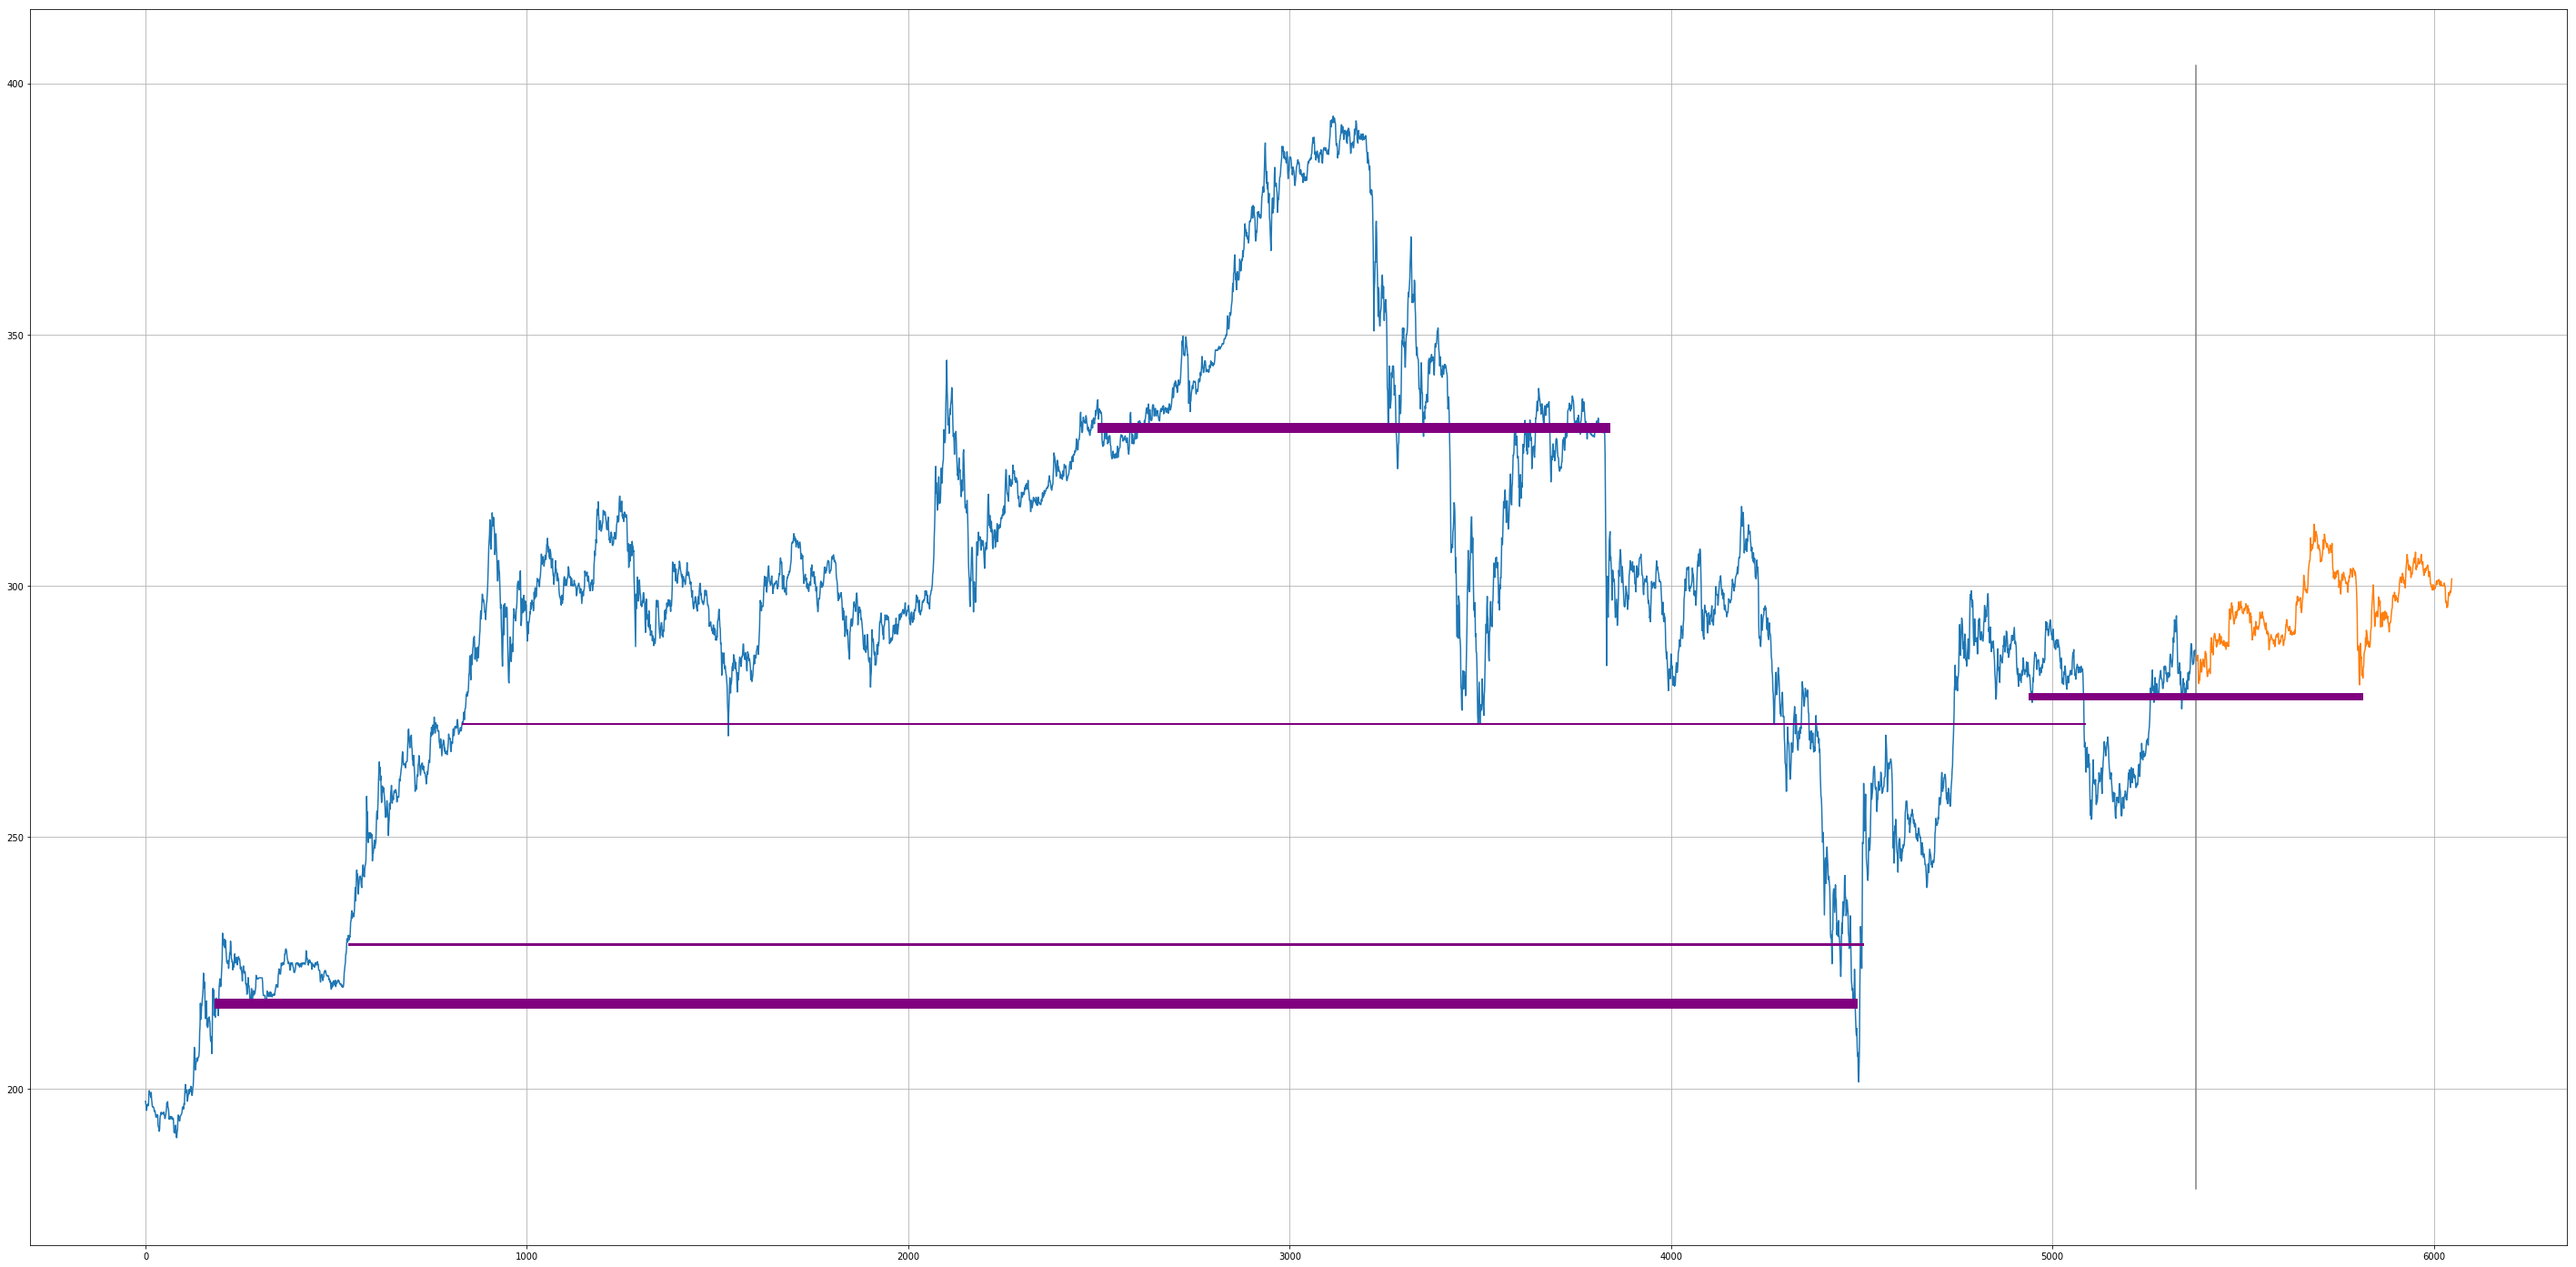

moving_overall_bin_max_volume=  3527537



PRICE BINS - OLD:


PRICE BINS - NEW:

bin=109, aggVol=   5620990, oPrc=217.00, nPrc=217.00, oMaxVol=736006.23, nMaxVol=736006.23, oScr=3.00, nScr=3.00


bin=115, aggVol=   6934745, oPrc=228.78, nPrc=228.78, oMaxVol=728282.02, nMaxVol=728282.02, oScr=0.74, nScr=0.74


bin=137, aggVol=  11077225, oPrc=272.48, nPrc=272.48, oMaxVol=460719.98, nMaxVol=460719.98, oScr=0.57, nScr=0.57


bin=139, aggVol=  12355370, oPrc=277.56, nPrc=278.01, oMaxVol=31880.19, nMaxVol=517056.78, oScr=0.00, nScr=2.38


bin=167, aggVol=  13609393, oPrc=331.49, nPrc=331.49, oMaxVol=592699.50, nMaxVol=592699.50, oScr=3.00, nScr=3.00



TRADING_HISTORY:


ORDERS:


WALLET: USDT  100.0000, ETH    0.0000 => in total USDT  100.0000, spent on fees USDT    0.0000

elapsed_time of print_verbose_result_with_graph=0.9083549976348877


WALLET: USDT  100.0000, ETH    0.0000 => in total USDT  100.0000, spent on fees USDT    0.0000



draw_profit_graph [thread=<Thread(Thread-374, started 140552220243712)>]



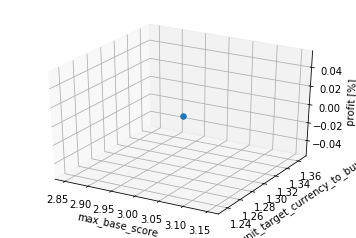

In [156]:
trading_fee_decimal = 0.0025

old_week_count = 8

# DO NOT DELETE
# (old_week_count, new_week_count, max_base_score, volume_unit_target_currency_to_buy_in_percents)
# (8, 20, 3, 5)    => WALLET: USDT 162.164, BTC 0.0018 => in total USDT 170    (.8 multiplication of final_balance)
# (8, 10, 3, 2.3)  => WALLET: USDT 125.2,   BTC 0.0003 => in total USDT 126.4  (.8 multiplication of final_balance)
# (8, 5, 2.3, 3.7) => WALLET: USDT 117.77,  BTC 0.0002 => in total USDT 118.62 (.8 multiplication of final_balance)
# currency_pair = CurrencyPair('USDT', 'BTC', 0.0005)

# DO NOT DELETE
# (old_week_count, new_week_count, max_base_score, volume_unit_target_currency_to_buy_in_percents)
# (8, [5, 10, 15, 20], 1.1, 5) => 20 weeks => WALLET: USDT   83.5890, ETH    0.3974 => in total USDT  202.0067
# (8, 20, 1.1, 4) => WALLET: USDT 127.4,  ETH 0.27   => in total USDT 209.6    (.8 multiplication of final_balance)
# (8, 10, 3, 5)   => WALLET: USDT 98,     ETH 0.1253 => in total USDT 136.1642 (.8 multiplication of final_balance)
# (8, 5, 1.1, 5)  => WALLET: USDT 113.03, ETH 0.0043 => in total USDT 114.3438 (.8 multiplication of final_balance)
currency_pair = CurrencyPair('USDT', 'ETH', 0.0005)

# DO NOT DELETE
# (old_week_count, new_week_count, max_base_score, volume_unit_target_currency_to_buy_in_percents)
# (8, 20, 2.6, 5) => WALLET: USDT 220.526, LTC 0.2208 => in total USDT 232.8 (.8 multiplication of final_balance)
# (8, 10, 2, 1)   => WALLET: USDT 27.3570, LTC 1.4877 => in total USDT 110   (.8 multiplication of final_balance)
# (8, 5, .8, 1)   => WALLET: USDT 25.6203, LTC 1.3536 => in total USDT 101   (.8 multiplication of final_balance)
# currency_pair = CurrencyPair('USDT', 'LTC', 0.0005)

# DO NOT DELETE
# (old_week_count, new_week_count, max_base_score, volume_unit_target_currency_to_buy_in_percents)
# (8, [5, 10, 15, 20], 3, 1.3) => 20 weeks => WALLET: USDT    0.0000, XMR    1.5538 => in total USDT  144.8745
# currency_pair = CurrencyPair('USDT', 'XMR', 0.0005)

# DO NOT DELETE
# currency_pair = CurrencyPair('BTC', 'ETH', 0.0005)
# currency_pair = CurrencyPair('BTC', 'LTC', 0.0005)
# currency_pair = CurrencyPair('BTC', 'XMR', 0.0005)

currency_pair_evaluator = CurrencyPairEvaluator(currency_pair)
# DO NOT DELETE
# currency_pair_evaluator.evaluate_one_time_frame_and_draw_and_close((1, 0))
currency_pair_evaluator.evaluate_multiple_time_frames_and_draw([(5, 15), (5, 12), (5, 9), (5, 6), (5, 3), (5, 0)])